In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore 
from scipy.sparse.linalg import eigsh

from skimage.measure import block_reduce

import sys
sys.path.append('../utils')
sys.path.append('../dFC')
import widefield_utils
import connectivity_measures

In [3]:
import numpy as np
import os

In [4]:
final_mask = np.load(r"/home/k21208334/calcium_analyses/data/dowsampled_tight_mask.npy")
good_indices = np.ravel(final_mask)

In [6]:
h=300
w=304
H = 50
W = 51
connectivity_thr = 0.2
window_size = 140

start = 0
end = 25000
connectivity_thr = 0.2

names = ["NXAK22.1A","NXAK14.1A","NXAK7.1B","NXAK4.1B","NRXN78.1D","NRXN78.1A"]
names_knock = ["NXAK24.1C","NXAK20.1B","NXAK16.1B","NXAK10.1A","NXAK4.1A","NRXN71.2A"]

In [6]:
for name in names+names_knock: # first one already done

    print("\n starting: ",name)
    walking = np.load("/home/k21208334/calcium_analyses/data/walking/"+name+".npy")
    base_directory = r"/home/k21208334/calcium_analyses/data/" + name + "/"
    registered_directory = r"/home/k21208334/calcium_analyses/data/registration_data/" + name + "/"
    sample = load_registered_sample(base_directory,registered_directory,start,end)
    coarse_sample = block_reduce(sample, block_size=(6,6,1), func=np.mean) 
    #  connectivity: flatten data
    H = np.shape(coarse_sample)[0]
    W = np.shape(coarse_sample)[1]
    all_signals = np.reshape(coarse_sample,(H*W,end))
    # remove zero signals based on mask!
    good_indices = np.ravel(final_mask)
    signals = all_signals[good_indices,:]
    
    # ok now I have the signals
    leading_eigenvectors = np.empty((0,signals.shape[0]))

    for i in range(signals.shape[1]):
        matrix = connectivity_measures.get_instantaneous_matrix(window_size,signals,i)
        eigenvalue, eigenvector = eigsh(matrix, k=1)
        if np.sum(eigenvector)>0:
            eigenvector=-eigenvector;
        # normalize eigenvector
        eigenvector = eigenvector/(np.linalg.norm(eigenvector))
        leading_eigenvectors=np.vstack((leading_eigenvectors,eigenvector.T))
        
    tosave = '/home/k21208334/calcium_analyses/data/leading_eigenvectors/' + name
    np.save(tosave,leading_eigenvectors)


 starting:  NXAK22.1A

 starting:  NXAK14.1A

 starting:  NXAK7.1B

 starting:  NXAK4.1B

 starting:  NRXN78.1D

 starting:  NRXN78.1A

 starting:  NXAK24.1C

 starting:  NXAK20.1B

 starting:  NXAK16.1B

 starting:  NXAK10.1A

 starting:  NXAK4.1A

 starting:  NRXN71.2A


# NOTE: WHEN I makes sense, this will go in the Analyze part!

In [9]:
#eigenvectors_wild = np.empty((0,signals.shape[0]))
#eigenvectors_knock = np.empty((0,signals.shape[0]))
eigenvectors_all = np.empty((0,1258)) # to change this!!!!!

# load clustered data 

for name in names+names_knock:

    data = '/home/k21208334/calcium_analyses/data/leading_eigenvectors/' + name + ".npy"
    centr = np.load(data)
    eigenvectors_all = np.vstack((eigenvectors_all,centr))

K MEANS CLUSTERING

In [10]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(eigenvectors_all)
    Sum_of_squared_distances.append(km.inertia_)

/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the va

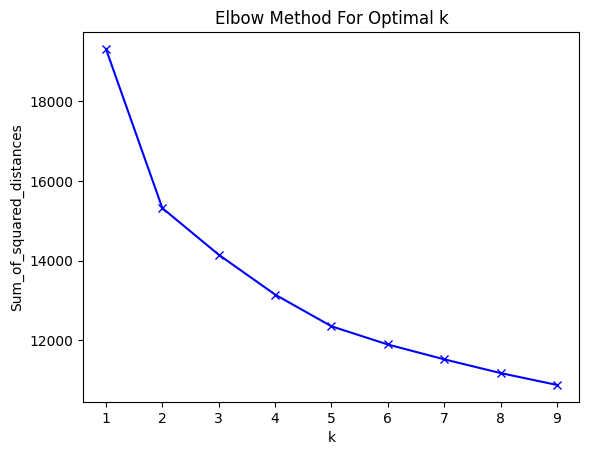

In [11]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [12]:
# once n of clusters decided...

In [37]:
optimal_k = 12

km = KMeans(n_clusters=optimal_k)
km = km.fit(eigenvectors_all)

/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


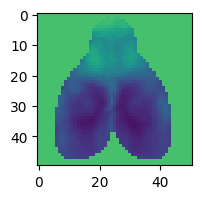

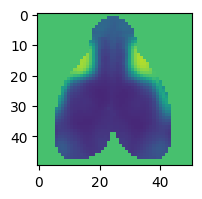

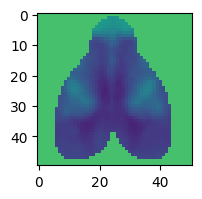

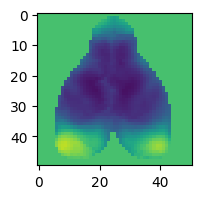

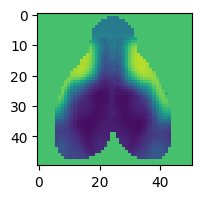

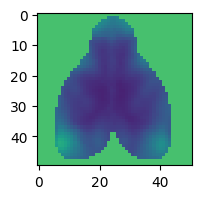

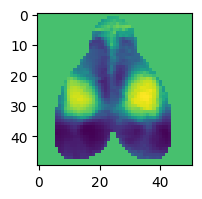

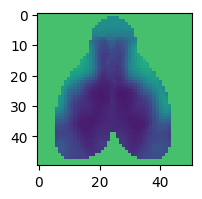

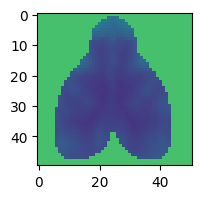

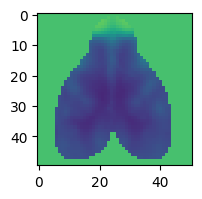

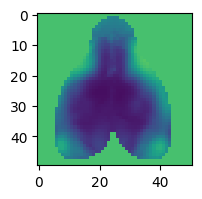

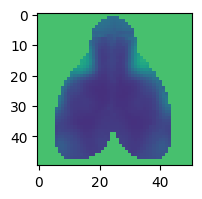

In [38]:
for i,centroid in enumerate(km.cluster_centers_):
    fig = plot_centrality(centroid,H,W,good_indices,km.cluster_centers_.min(),km.cluster_centers_.max())
    fig.set_size_inches(2,2)
    #fig.savefig(str(i)+"centroid")


MEAN SHIFT CLUSTERING -> did not work
TRY BISECTING K MEANS

In [21]:
from sklearn.cluster import BisectingKMeans
bisect_means = BisectingKMeans(n_clusters=5, random_state=0).fit(eigenvectors_all)


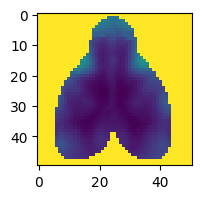

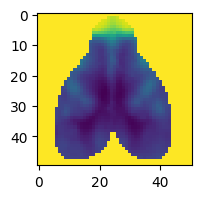

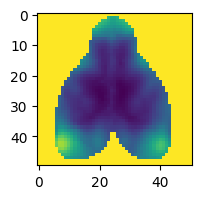

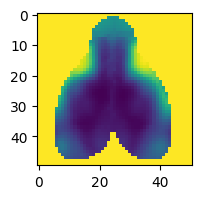

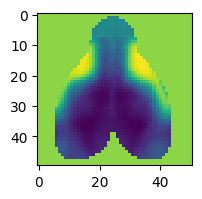

In [22]:
cluster_centers = bisect_means.cluster_centers_

for centroid in cluster_centers:
    fig = connectivity_measures.show_array(centroid,H,W,good_indices)
    fig.set_size_inches(2,2)
    
# QUESTION: maybe 5 is the right number and we just go with this?

Now try ICA on leida to see the components...

In [23]:
from sklearn.decomposition import FastICA


n_comp = 10
model = FastICA(n_components = n_comp,whiten='unit-variance')
S = model.fit_transform(eigenvectors_all) # started 10.04

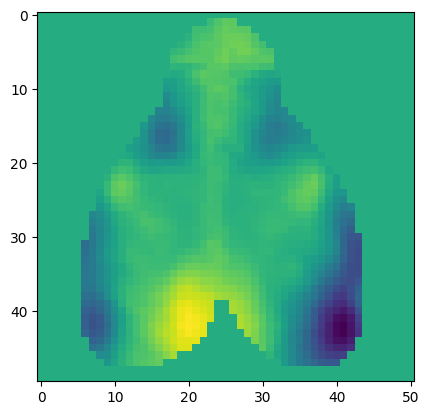

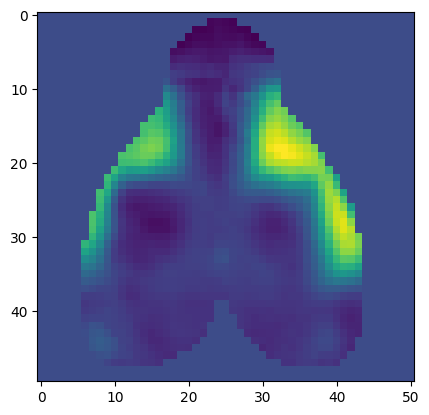

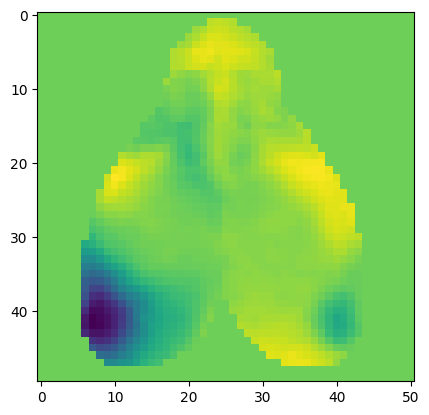

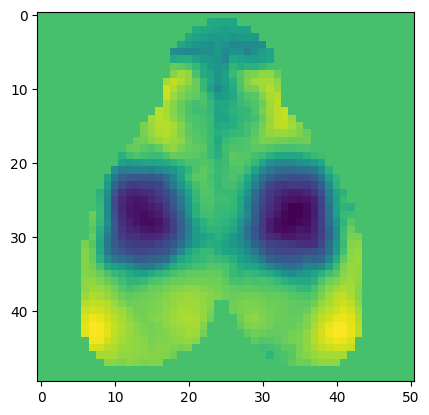

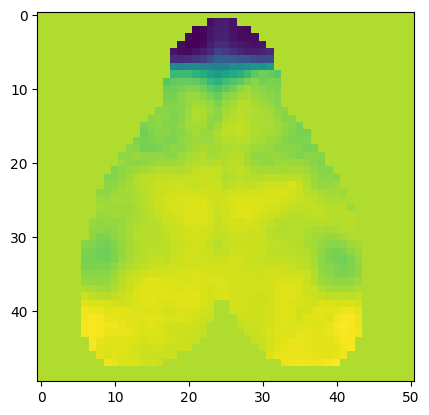

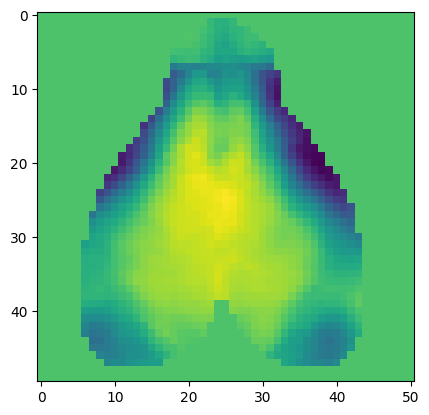

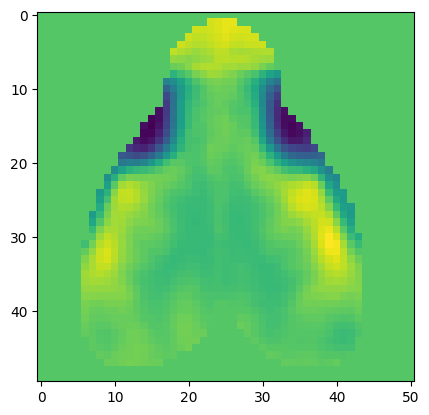

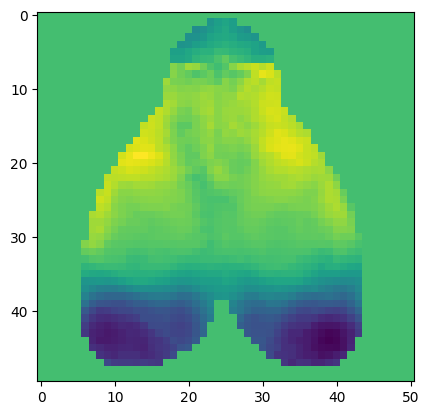

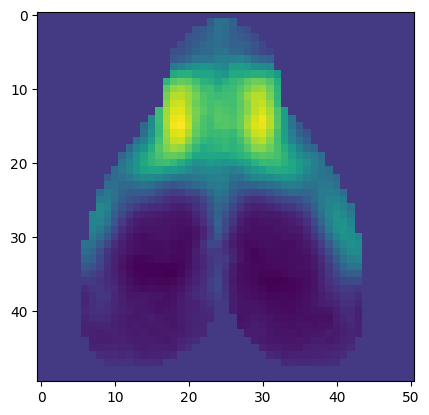

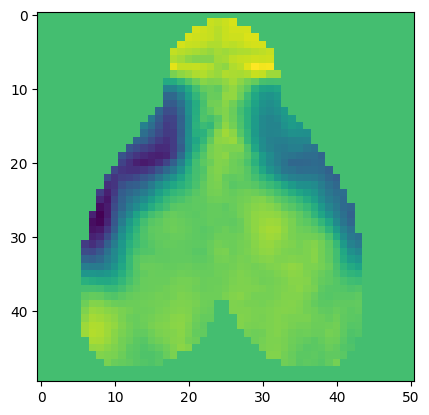

In [26]:
components = model.mixing_
size = eigenvectors_all.shape[1]

for i in range(n_comp):
    connectivity_measures.show_array(components[:,i],H,W,good_indices)

Now I define similarity of the components based on corrcoef of signals (as done in the paper)

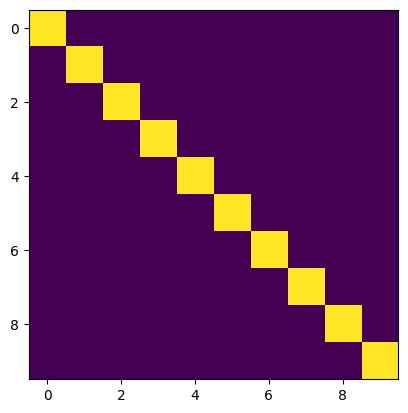

In [30]:
similarity_matrix = np.corrcoef(S.T)
plt.imshow(similarity_matrix)

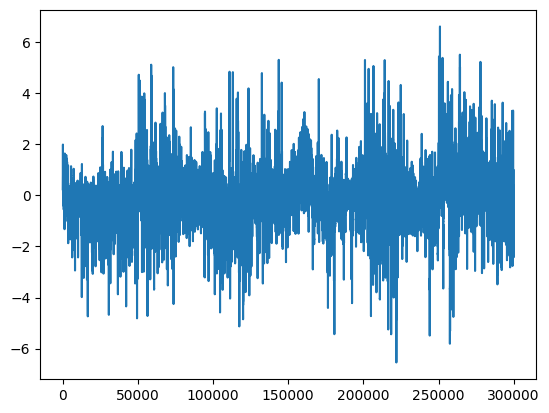

In [44]:
plt.plot(S[:,0]) # show a component

Let's then just implement a pipeline to define states based on this and then we'll see. We are working with leading eigenvectors, so actually it's ok to have negative values. However, all signals have unit variance, so it makes no sense to have a dominant component. SO let's try k means and see what happens

In [39]:
S.shape

(300000, 10)

In [42]:
from sklearn.cluster import KMeans
k = 6

km = KMeans(n_clusters=5)
km = km.fit(S)

/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


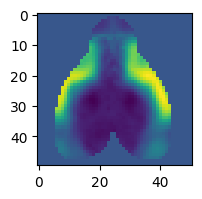

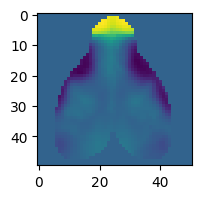

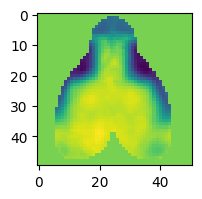

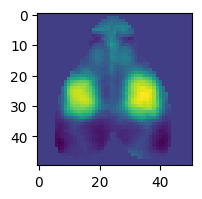

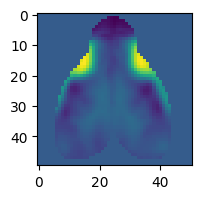

In [56]:
cluster_centers = km.cluster_centers_
centroids = np.dot(components,cluster_centers.T)

for centroid in centroids.T:
    fig = connectivity_measures.show_array(centroid,H,W,good_indices)
    fig.set_size_inches(2,2)


# Wonderful news! kmeans on top of ICA gives us the cool, symmetric, interesting components!

In [ ]:
# let's do for completeness elbow rule

In [57]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(S)
    Sum_of_squared_distances.append(km.inertia_)

/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the va

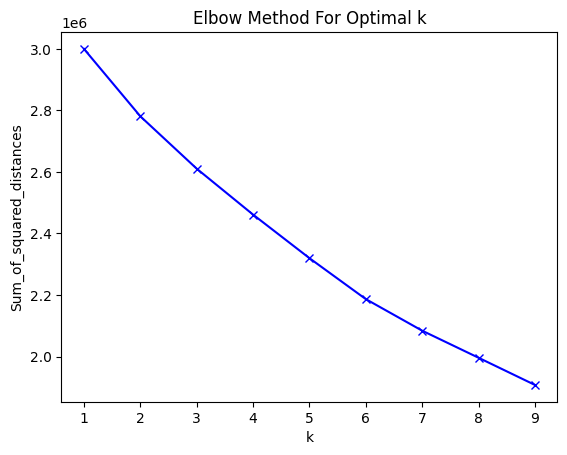

In [58]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [80]:
# we decide that our k is 5
k = 8

km = KMeans(n_clusters=k)
km = km.fit(S)


/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [81]:
# let's define fractional occupancies. REALITY is just a dream which is good enough to make us survive.

n_individuals = len(names+names_knock)
fractional_occupancies_walk = np.zeros((n_individuals,k))
fractional_occupancies_rest = np.zeros((n_individuals,k))


for i,name in enumerate(names+names_knock):
    for j in range(k):
        walking = np.load('/home/k21208334/calcium_analyses/data/walking/'+name+'.npy')
        timeseries_labels = km.labels_[int(i*end):int((i+1)*end)]==j
        fractional_occupancies_walk[i,j] = np.sum(timeseries_labels[walking])/len(timeseries_labels[walking])
        fractional_occupancies_rest[i,j] = np.sum(timeseries_labels[~walking])/len(timeseries_labels[~walking])


In [83]:
# do statistics

/tmp/ipykernel_3837931/34287459.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots()


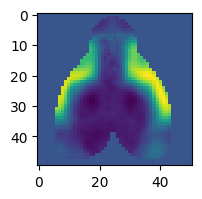

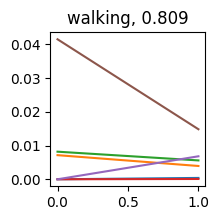

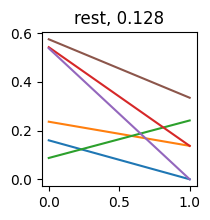

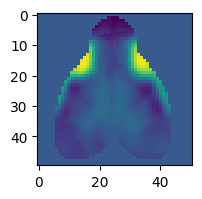

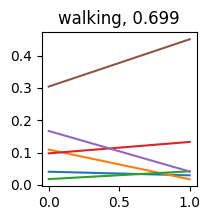

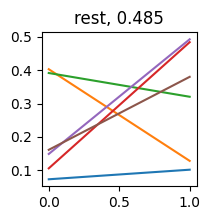

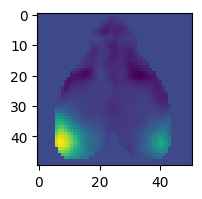

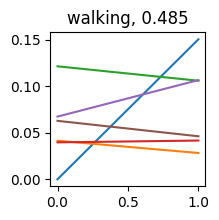

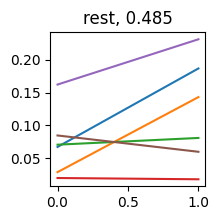

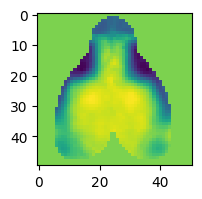

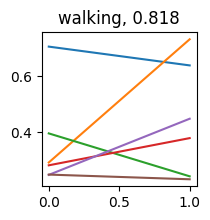

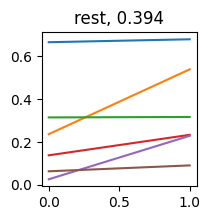

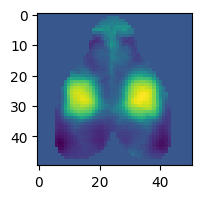

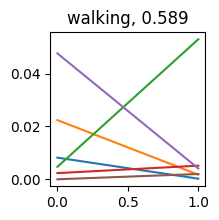

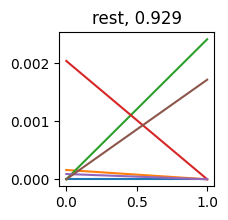

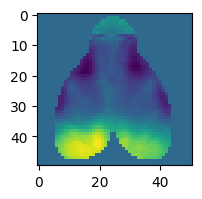

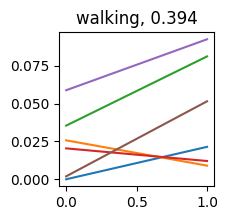

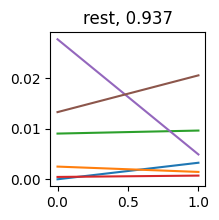

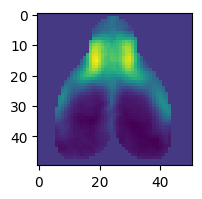

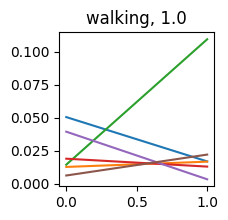

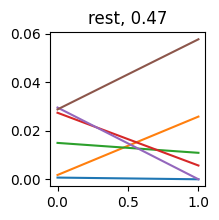

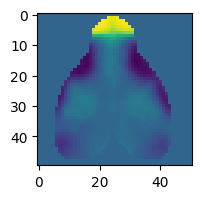

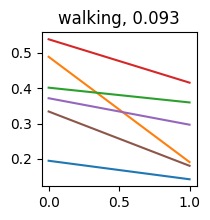

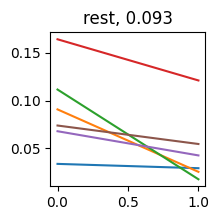

In [82]:
from scipy.stats import mannwhitneyu

cluster_centers = km.cluster_centers_
centroids = np.dot(components,cluster_centers.T)

for i,centroid in enumerate(centroids.T):
    fig = connectivity_measures.show_array(centroid,H,W,good_indices)
    fig.set_size_inches(2,2)
    fig,ax = plt.subplots()
    ax.plot([fractional_occupancies_walk[0:6,i],fractional_occupancies_walk[6:12,i]])
    fig.set_size_inches(2,2)
    test = mannwhitneyu(fractional_occupancies_walk[0:6,i],fractional_occupancies_walk[6:12,i])
    pvalue = test.pvalue
    ax.set_title('walking, '+str(round(pvalue,3)))
    
    fig,ax = plt.subplots()
    ax.plot([fractional_occupancies_rest[0:6,i],fractional_occupancies_rest[6:12,i]])
    fig.set_size_inches(2,2)
    test = mannwhitneyu(fractional_occupancies_rest[0:6,i],fractional_occupancies_rest[6:12,i])
    pvalue = test.pvalue
    ax.set_title('rest, '+str(round(pvalue,3)))
    